# Настройки/Импорты

In [1]:
!pip install transformers==4.45.2
!pip install evaluate
!pip install seaborn==0.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 57.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [2]:
import os # для взаимодействия с системой
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import random as random # для работы со случайностью
import pickle # для сохранения и загрузки объектов
from tqdm.auto import tqdm # для отслеживания прогресса

from datasets import Dataset, load_dataset, load_from_disk # для работы с HuggingFace датасетами

import torch # для работы с моделями torch
from transformers import T5ForConditionalGeneration, T5Tokenizer # для работы с T5 моделью
from transformers import DataCollatorForSeq2Seq # для сборщика данных (чтобы)
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer # для обучения модели
from transformers import EarlyStoppingCallback # callback для ранней остановки обучения

import time # для отслеживания времени выполнения
import matplotlib.pyplot as plt # для построения графиков
import seaborn as sns # для построения красивых графиков
import evaluate # для подсчёта метрик

In [3]:
DATA_DIR = "/kaggle/working/data/" # путь до папки с данными
RESULTS_DIR = "/kaggle/working/results/" # путь до папки с результатами вычислений
EMBEDDING_DIR = "/kaggle/working/embeddings/" # путь до папки с эмбеддингами
MODELS_DIR = "/kaggle/working/models/" # путь до папки с моделями
MODEL_NAME = "utrobinmv/t5_translate_en_ru_zh_small_1024" # название модели для перевода
DATASET_NAME_HF = "aiana94/polynews-parallel"
DATASET_NAME_LOC = "polynews-parallel"

MAX_SEQUENCE_LEN = 256 # оптимальное число токенов в документе (если не достаёт — padding, если перебор — truncation), определялось по гистограмме распределения числа токенов в текстах

RANDOM_STATE = 42 # число для задания случайности
TEST_SIZE = 0.2 # размер тестовой выборки
TEST_MAX_SAMPLES = 10000 # максимальное число тестовых примеров
TRAIN_MAX_SAMPLES = 40000 # максимальное число обучающих примеров

EPOCHS = 10 # число эпох обучения
EPOCHS_PATIENCE = 2 # число эпох без изменения наблюдаемой метрики, после которого обучение прекратится
LEARNING_RATE = 0.00001 # learning rate
BATCH_SIZE = 24 # размер батча (число сэмплов, передаваемых в модель одновременно => чем больше значение - тем быстрее обучение, но хуже качество из-за аккумуляции градиентов)

In [4]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Девайс: {DEVICE}.")

Девайс: cpu.


# Работа с датасетом

In [5]:
dataset = load_dataset(DATASET_NAME_HF, name="eng_Latn-rus_Cyrl") # скачивание датасета, name — название subset_а с HuggingFace
# dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC) # локальное сохранение датасета (в формате arrow)
dataset

README.md:   0%|          | 0.00/107k [00:00<?, ?B/s]

train.parquet.gzip:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/176441 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'provenance'],
        num_rows: 176441
    })
})

In [6]:
dataset["train"][0]

{'src': 'Parliament Does Not Support Amendment Freeing Tymoshenko',
 'tgt': 'Парламент не поддерживает поправку, дающую свободу Тимошенко',
 'provenance': 'wmtnews'}

In [7]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
# tokenizer.save_pretrained(MODELS_DIR + MODEL_NAME) # сохранение токенизатора
tokenizer

tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

T5Tokenizer(name_or_path='utrobinmv/t5_translate_en_ru_zh_small_1024', vocab_size=65000, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_

In [8]:
def preprocess_function(data: Dataset, random_state=RANDOM_STATE):
    random.seed(random_state) # Set the random number generator to a fixed sequence.
    samples_count = len(dataset["train"]) # общее число сэмплов в датасете

    reflected_idx = set(random.sample(range(0, samples_count), int(samples_count/2))) # индексы отражаемых сэмплов (set — для сортировки и удобного вычитания)
    regular_idx = set(range(0, samples_count)) - reflected_idx

    data["new_src"] = ["translate to ru: " + sample if idx in regular_idx else "translate to en: " + data["tgt"][idx] for idx, sample in enumerate(data["src"])]
    data["new_tgt"] = [sample if idx in regular_idx else data["src"][idx] for idx, sample in enumerate(data["tgt"])]
    model_inputs = tokenizer(data["new_src"], text_target=data["new_tgt"], max_length=MAX_SEQUENCE_LEN, return_tensors="pt", truncation=True, padding=True)
    return model_inputs

In [9]:
dataset = dataset.map(preprocess_function, batched=True)
dataset = dataset.remove_columns(["provenance", "src", "tgt"]) # удаление ненужной колонки
dataset = dataset.rename_column("new_src", "src") # переименовываем колонку
dataset = dataset.rename_column("new_tgt", "tgt") # переименовываем колонку
dataset = dataset["train"].train_test_split(test_size=TEST_SIZE, shuffle=True, seed=RANDOM_STATE) # разбиение датасета на тестовую и обучающую выборки ()
dataset

Map:   0%|          | 0/176441 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 141152
    })
    test: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 35289
    })
})

In [10]:
dataset["train"][0]

{'src': "translate to ru: Diaspora blogger Jumbie's Watch was also confused as to how Minister St. Rose-Greaves was spared, since he remembers her publicly accepting responsibility. ",
 'tgt': "Один из авторов блога Jumbie's Watch также был потрясен тем, как министр Сент-Роуз Гривз была избавлена от ответственности, хотя помнится она публично признала её. ",
 'input_ids': [21809,
  19,
  4,
  2248,
  31,
  1985,
  32668,
  9922,
  10256,
  3948,
  850,
  887,
  26547,
  38,
  13,
  14997,
  58,
  147,
  31672,
  53,
  19,
  547,
  1736,
  1058,
  5,
  20365,
  9,
  372,
  12878,
  5752,
  58,
  19069,
  88,
  3,
  697,
  131,
  6057,
  13,
  294,
  21000,
  38768,
  6016,
  5,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [11]:
!pip show transformers

Name: transformers
Version: 4.45.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: kaggle-environments, peft, sentence-transformers


In [12]:
dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC + "_t5_processed") # локальное сохранение датасета (в формате arrow)
# dataset = load_from_disk(DATA_DIR + DATASET_NAME_LOC + "_t5_processed") # загрузка локально сохранённого датасета

Saving the dataset (0/1 shards):   0%|          | 0/141152 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35289 [00:00<?, ? examples/s]

# Работа с моделью

In [13]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model.save_pretrained(MODELS_DIR + MODEL_NAME, from_pt=True) # сохранение модели
model

config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/221M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(65100, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(65100, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [14]:
# tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
# tokenizer.save_pretrained(MODELS_DIR + MODEL_NAME) # сохранение токенизатора
# tokenizer

In [15]:
vocab_len = tokenizer.vocab_size # размер словаря
print(f"Размер словаря токенизатора: {vocab_len}, с учётом особых токенов: {len(tokenizer.get_vocab())}.")

Размер словаря токенизатора: 65000, с учётом особых токенов: 65100.


In [16]:
word2id = {} # словарь соответствия слова его id_шнику
id2word = {} # словарь соответствия id_шника слову
for word, id in tokenizer.get_vocab().items(): # идём по словам в словаре
    word2id[word] = id # заполняем словарь соответствия слова его id_шнику
    id2word[id] = word # заполняем словарь соответствия id_шника слову

In [17]:
prefix = "translate to en: "
src_text = prefix + "Цель разработки — предоставить пользователям личного синхронного переводчика."

tokens_encoded = tokenizer(src_text, max_length=tokenizer.max_len_single_sentence, return_tensors="pt", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
print(f"Пример токенизации документа: {tokens_encoded}.") # пример токенизации первого документа

Пример токенизации документа: {'input_ids': tensor([[21809,    19,  1904,    31, 16069,  4201,  1248,  9872, 24863, 24371,
             4, 26900,   155,  5564, 14473,     5,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}.


In [18]:
for token in tokens_encoded['input_ids'][0].numpy(): # идём по токенам
    print(f"{token} — {id2word[token]}") # выводим токен (id) и соответствующее ему слово

21809 — ▁translate
19 — ▁to
1904 — ▁en
31 — :
16069 — ▁Цель
4201 — ▁разработки
1248 — ▁—
9872 — ▁предоставить
24863 — ▁пользователям
24371 — ▁личного
4 — ▁
26900 — синхрон
155 — ного
5564 — ▁перевод
14473 — чика
5 — .
1 — </s>


In [19]:
tokens_generated = model.generate(**tokens_encoded)

# output = tokenizer.batch_decode(tokens_generated, skip_special_tokens=True)
output = tokenizer.batch_decode(tokens_generated, skip_special_tokens=False)
print(output)

['<pad> The purpose of the development is to provide users with a personal translator.</s>']


# Baseline (замер основных метрик)

In [20]:
def translate(model, tokenizer, texts) -> tuple:
    tokens_count = [] # список под количество токенов в тексте
    latency = [] # список под величину задержки между запуском модели и выводом ответа
    translations = [] # список под переводы

    if isinstance(texts, str): # если пришёл объект типа строки
        texts = [texts] # делаем из объекта список с одним элементом
    elif isinstance(texts, Dataset) or isinstance(texts, dict): # если пришёл объект типа Dataset или словарь (полученный с помощью среза объекта Dataset)
        texts = texts["src"] # берём из него только текста, что нужно переводить

    model.eval() # перевод модели в режим оценивания (dropout перестаёт работать, а BatchNorm собирать статистику)

    with torch.no_grad(): # отключаем подсчёт градиентов
        #================================ Быстрый перевод батчами ==========================================
        # tokens_encoded = tokenizer(texts, max_length=tokenizer.max_len_single_sentence, return_tensors="pt", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
        # tokens_generated = model.generate(**tokens_encoded)
        # translations = tokenizer.batch_decode(tokens_generated, skip_special_tokens=True) # декодирование последовательности токенов (аналог .decode, но для работы с несколькими последовательностями сразу), skip_special_tokens — выводить ли специальные токены
        #-------------------------------- Перевод для учёта времени работы ---------------------------------
        for text in tqdm(texts):
            # text = "translate to ru: " + text # добавляем промпт для того, чтобы модель знала, что нужно делать
            time_start = time.time() # замеряем время начала работы  с моделью

            tokens_encoded = tokenizer(text, max_length=tokenizer.max_len_single_sentence, return_tensors="pt", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
            tokens_count.append(tokens_encoded["input_ids"].shape[1]) # запоминаем количество токенов

            tokens_generated = model.generate(**tokens_encoded) # генерируем новую последовательность токенов (переводим текст)
            translations.append(tokenizer.decode(tokens_generated[0], skip_special_tokens=True)) # декодирование последовательности токенов, skip_special_tokens — выводить ли специальные токены

            latency.append(time.time()  - time_start)
        #---------------------------------------------------------------------------------------------------
    
    return tokens_count, latency, translations

In [21]:
tokens_count, latency, translations = translate(model, tokenizer, dataset["test"][:TEST_MAX_SAMPLES])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
translations[:5]

['Фонд Клинтона и телекоммуникационный оператор МТН объединили усилия для борьбы с поздней диагностикой тестирования на ВИЧ у новорожденных. Это новое мобильное устройство будет включать в себя принтер карманного размера и будет распространено в 682 центрах тестирования по всей стране.',
 'The banning of two popular series, however, shows that party leadership expands the authority to selectively censor and regulate content running against their ideology.',
 'Неудивительно, что слова становятся заклинаниями, чтобы помочь остановить плач, помочь ребенку поспать или выразить поддержку или надежду.',
 'Supporters are now appealing to UN Secretary-General Ban Ki-moon to support international human rights commitments and demand the immediate release of Bassel.',
 'Эта история Джойса Хакеля изначально появилась в При.орге 14 июня 2017 года.']

In [23]:
dataset["test"]["src"][:5]

['translate to ru: The Clinton Foundation and the telecommunications operator MTN have partnered to fight against the late diagnosis of HIV testing in newborns. This new mobile device will include a pocket-size printer and will be distributed in 682 testing centers across the country. ',
 'translate to en: Однако запрещение двух популярных сериалов показывает, что партийные руководства расширяют полномочия властей относительно избирательной цензуры и регулирования контента, идущего против их идеологии. ',
 'translate to ru: It is not surprising that words become spells to help stop the crying, help the child go to sleep, or express encouragement or hope. ',
 'translate to en: Сейчас сторонники обращаются к генеральному секретарю ООН Пан Ги Муну с просьбой оказать поддержку международным обязательствам в области прав человека и потребовать немедленного освобождения Басселя. ',
 'translate to ru: This story by Joyce Hackel originally appeared on PRI.org on June 14, 2017. ']

In [24]:
dataset["test"]["tgt"][:5]

['Фонд Клинтона предполагает внедрить устройство, оснащенное минипринтером, в 682 центрах по забору крови по всей стране. ',
 'Yet, as the takedown of the two popular online TV series indicated, the party guidelines empower authorities to arbitrarily and selectively censor and ban content that they find challenges their ideology. ',
 'Не удивительно, что слова становятся заклинаниями, для того чтобы помочь остановить плач, помочь ребенку заснуть, выразить поддержку или надежду. ',
 "Supporters are now turning to the United Nations’ Secretary-General Ban Ki-moon and asking for his support to uphold international commitments to human rights and demand Bassel's immediate and safe release. ",
 'Эта статья Джойс Хакел изначально была опубликована на PRI.org 14 июня 2017г. ']

In [25]:
if not os.path.exists(RESULTS_DIR + MODEL_NAME):
    os.makedirs(RESULTS_DIR + MODEL_NAME)

with open(RESULTS_DIR + MODEL_NAME + "/tokens_count.pkl", "wb") as f: # открываем файл для записи по битам (wb)
    pickle.dump(tokens_count, f) # сохраняем объект в файл f
with open(RESULTS_DIR + MODEL_NAME + "/latency.pkl", "wb") as f: # открываем файл для записи по битам (wb)
    pickle.dump(latency, f) # сохраняем объект в файл f
with open(RESULTS_DIR + MODEL_NAME + "/translations.pkl", "wb") as f: # открываем файл для записи по битам (wb)
    pickle.dump(translations, f) # сохраняем объект в файл f

In [26]:
# with open(RESULTS_DIR + MODEL_NAME + "/tokens_count.pkl", "rb") as f: # открываем файл для чтения по битам (rb)
#     tokens_count = pickle.load(f) # загружаем объект из файла
# with open(RESULTS_DIR + MODEL_NAME + "/latency.pkl", "rb") as f: # открываем файл для чтения по битам (rb)
#     latency = pickle.load(f) # загружаем объект из файла
# with open(RESULTS_DIR + MODEL_NAME + "/translations.pkl", "rb") as f: # открываем файл для чтения по битам (rb)
#     translations = pickle.load(f) # загружаем объект из файла

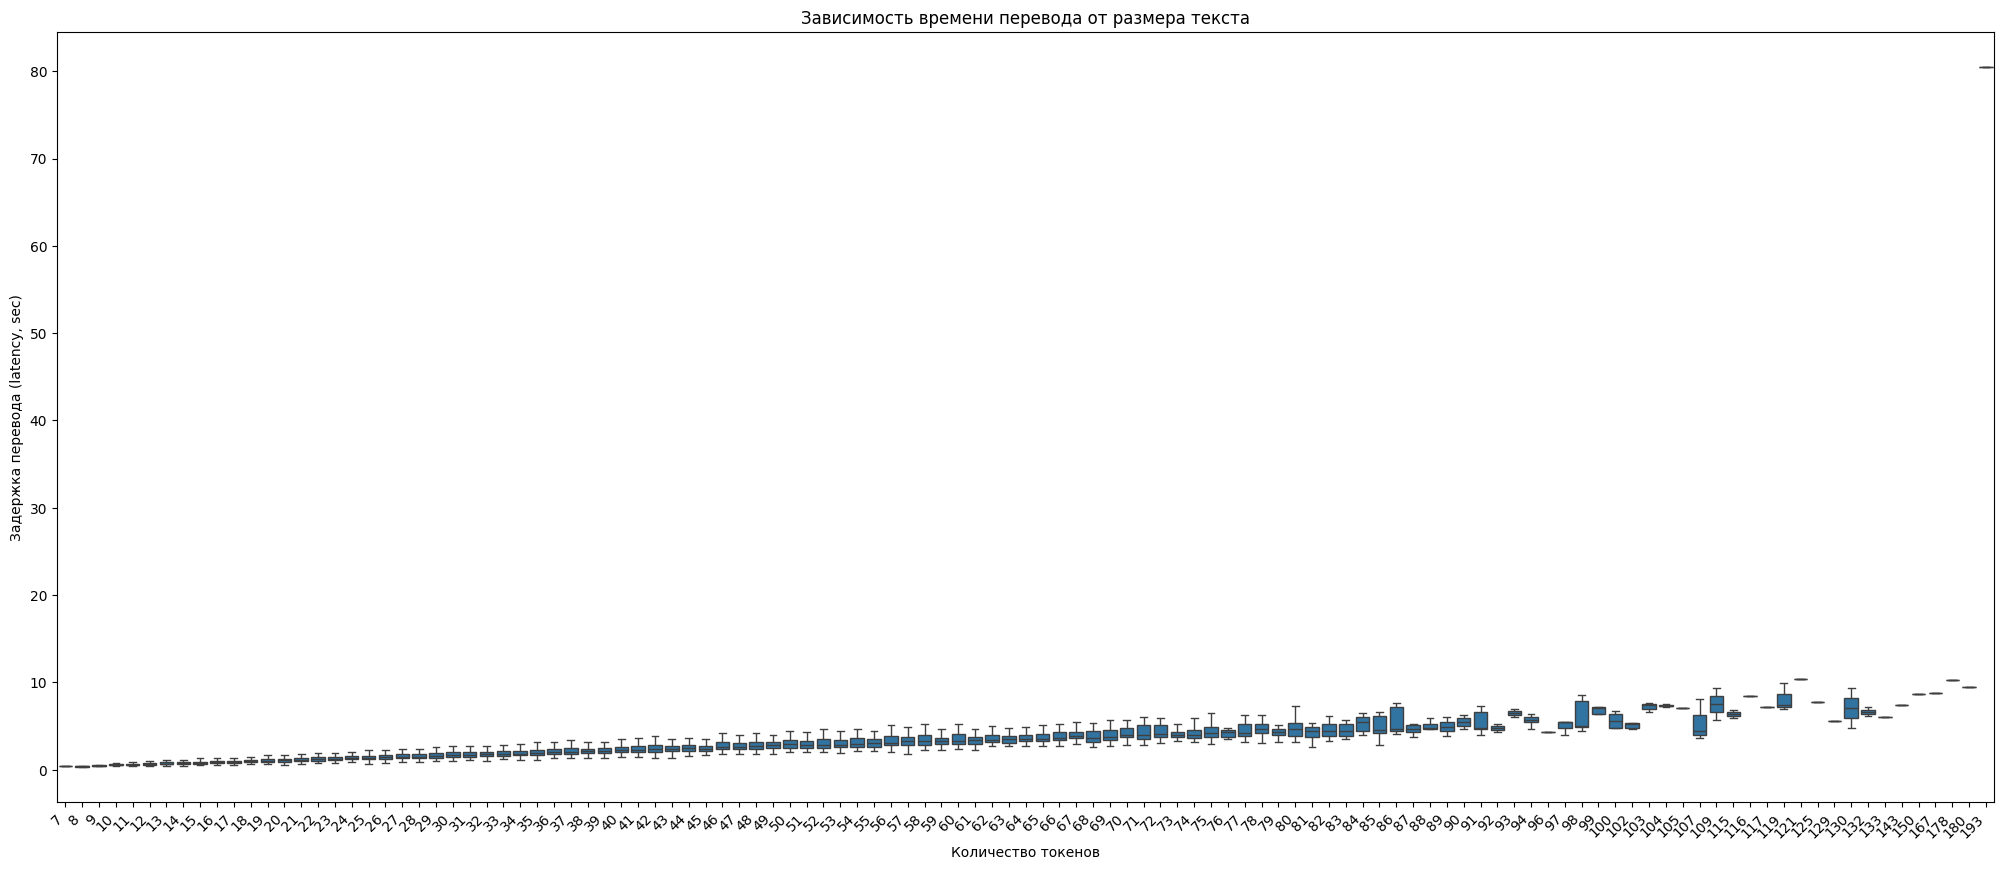

In [27]:
plt.figure(figsize=(25,10)) # задание размера фигуры
sns.boxplot(x=tokens_count, y=latency, showfliers=False) # строим "ящики с усами", showfliers — отображать ли выбросы
plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Зависимость времени перевода от размера текста") # название фигуры
plt.xlabel("Количество токенов") # подпись по оси x
plt.ylabel("Задержка перевода (latency, sec)") # подпись по оси y
plt.show() # показ фигуры

In [28]:
results = pd.DataFrame({"Tokens count": tokens_count, "Latency": latency}) # собираем данные в DataFrame
results.sort_values(by=["Tokens count"], inplace=True)
results.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True - перезаписываем существующий датасет)
results

,Tokens count,Latency
0,7,0.437661
1,8,0.393617
2,8,0.306902
3,8,0.471448
4,9,0.400932
...,...,...
9995,150,8.623867
9996,167,8.729420
9997,178,10.214590
9998,180,9.427525


In [29]:
stats = results.groupby(by="Tokens count", as_index=True).agg(mean=("Latency", "mean"),
                                                              std=("Latency", "std")
                                                             )
stats

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,mean,std
Tokens count,,
7,0.437661,NaN
8,0.390655,0.082313
9,0.505065,0.164941
10,0.560232,0.096192
11,0.621447,0.127444
...,...,...
150,8.623867,NaN
167,8.729420,NaN
178,10.214590,NaN


Удаляем записи-выбросы (оставляем только те записи, у которых отличие от среднего значения не более трёх стандартных отклонений).

In [30]:
outlier_indexes = []

for index in results.index:
    tokens_count_, latency_ = results.loc[index]
    if np.abs(latency_ - stats.loc[tokens_count_]["mean"]) > 3 * stats.loc[tokens_count_]["std"]:
        outlier_indexes.append(index)

results.drop(outlier_indexes, inplace=True)
results

,Tokens count,Latency
0,7,0.437661
1,8,0.393617
2,8,0.306902
3,8,0.471448
4,9,0.400932
...,...,...
9995,150,8.623867
9996,167,8.729420
9997,178,10.214590
9998,180,9.427525


Пересчитываем значения статистик без выбросов.

In [31]:
stats = results.groupby(by="Tokens count", as_index=True).agg(mean=("Latency", "mean"),
                                                              std=("Latency", "std")
                                                             )
stats

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,mean,std
Tokens count,,
7,0.437661,NaN
8,0.390655,0.082313
9,0.505065,0.164941
10,0.560232,0.096192
11,0.612416,0.112623
...,...,...
150,8.623867,NaN
167,8.729420,NaN
178,10.214590,NaN


Строим $y=ax+b$ линейную аппроксимацию графика, чтобы найти коэффициенты увеличения времени от размера текста.

In [32]:
a, b = np.polyfit(stats.index[:75], stats["mean"][:75], deg=1) # считаем линейную аппроксимацию (deg=1), [:75] — так как после идёт большой разброс по времени из-за малой представленности в датасете
print(f"Затрачиваемое время увеличивается, в среднем, на {a:.5f} секунд за каждый новый токен, при этом модель работает не менее {b:.5f} секунд.")

Затрачиваемое время увеличивается, в среднем, на 0.05851 секунд за каждый новый токен, при этом модель работает не менее -0.04145 секунд.


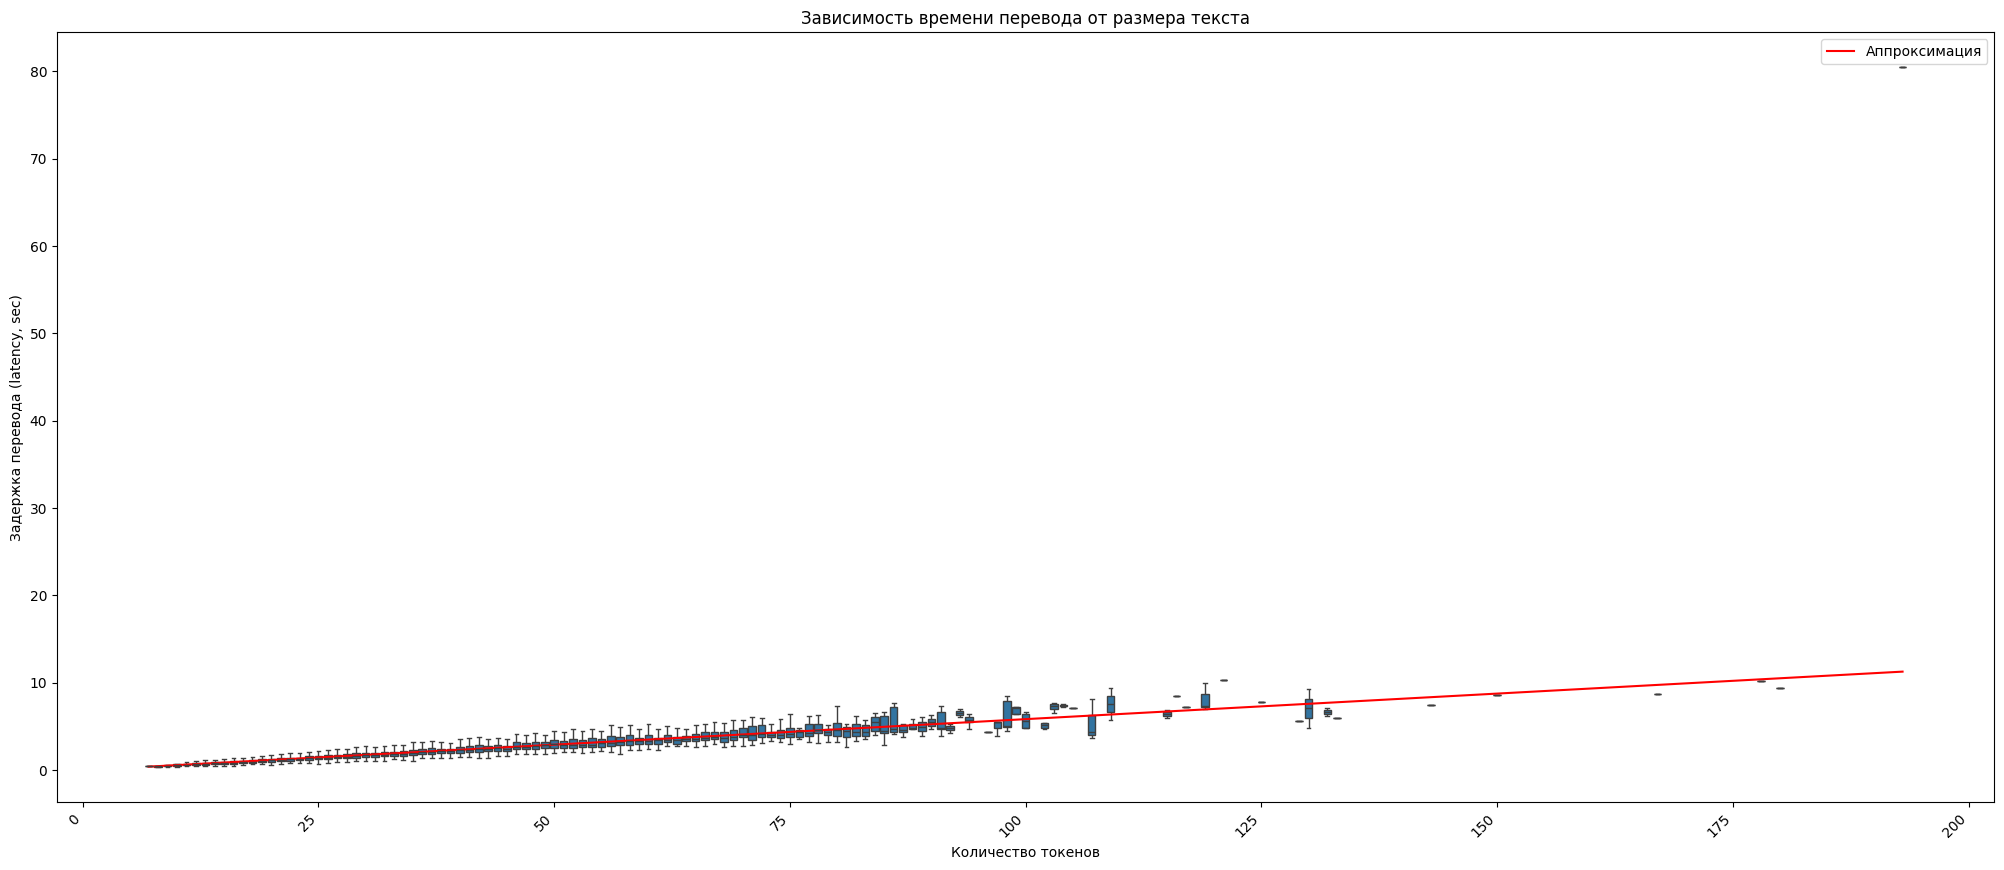

In [33]:
plt.figure(figsize=(25,10)) # задание размера фигуры
sns.boxplot(x=results["Tokens count"], y=results["Latency"], native_scale=True, showfliers=False) # строим "ящики с усами", showfliers — отображать ли выбросы, native_scale — воспринимать ли ось X как непрерывную (а не категориальную)

x = np.linspace(stats.index[0], stats.index[-1])
# x = stats.index.to_numpy() # рассмотренные значения по оси x для линейного графика
y = a * x + b
sns.lineplot(x=x, y=y, color="red", label="Аппроксимация")
# sns.pointplot(x=x, y=y, color="red", label="Аппроксимация") # pointplot в данном случае идёт как аналог линейного графика, у которого ось X воспринимается "категориально", то есть так же, как в boxplot

plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Зависимость времени перевода от размера текста") # название фигуры
plt.xlabel("Количество токенов") # подпись по оси x
plt.ylabel("Задержка перевода (latency, sec)") # подпись по оси y
plt.legend() # отображение подписей графиков
plt.show() # показ фигуры

In [34]:
metric_BLEU = evaluate.load("bleu") # загружаем метрику

In [35]:
metric_BLEU.compute(predictions=translations, references=dataset["test"]["tgt"][:TEST_MAX_SAMPLES]) # считаем значение метрики
# metric_BLEU.compute(predictions=translations, references=[[ref] for ref in dataset["test"]["tgt"][:TEST_MAX_SAMPLES]]) # считаем значение метрики

{'bleu': 0.25103210140897697,
 'precisions': [0.5580977107081525,
  0.3100788732128444,
  0.19415532624257525,
  0.12524236422391327],
 'brevity_penalty': 0.9856177485754505,
 'length_ratio': 0.9857201885610446,
 'translation_length': 221859,
 'reference_length': 225073}